In [1]:
import scanpy as sc
import os
import anndata as ad
# Python packages
import scvi
import bbknn
import scib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from scipy.stats import median_abs_deviation
from statsmodels import robust
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
import scanpy.external as sce
import sctk

/home/icb/yuting.wang/tools/miniconda3/envs/interoperability/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
from skdim.id import MLE
from sklearn.neighbors import NearestNeighbors

In [3]:
#check if GPU is available
import torch
if torch.cuda.is_available():
    print("GPU is available")
    print(f"Device count: {torch.cuda.device_count()}")
    print(f"Device name: {torch.cuda.get_device_name(0)}")
else:
    print("GPU is not available")

GPU is available
Device count: 1
Device name: Tesla V100S-PCIE-32GB


In [4]:
label_key = "scanvi_labels" #use transferred label from HLCA v1
batch_key = "sample_ID"
dataset_key= "study_name"
condition_key="condition"

library_key = "library_preparation_batch"

# Import the data

In [5]:
concat_path = './data/concat_inner_after_qc.h5ad'
adata = sc.read(concat_path)

Import HVG

In [6]:
hvg_path = './data/hvg_data.h5ad'
# adata_hvg.write(hvg_path)

In [7]:
adata_hvg = sc.read(hvg_path)

In [8]:
combined_palette = {
    'Yildirim_unpubl': '#D5006D',  # Dark Pink
    'Shaykhiev_publ': '#FFB6C1',  # Light Pink
    'Schiller_unpubl': '#800080',  # Purple
    'Nawijn_unpubl': '#0000FF',  # Standard Blue
    'lungMAP': '#1E90FF',  # Dodger Blue
    'Jones_Yosef_Teichmann_Farber_Sims_unpubl': '#4682B4',  # Steel Blue
    'Niklason_Kaminski_publ': '#87CEEB'  # Sky Blue
}

Import integrated object

- library_key as integration key

In [9]:
adata_scvi = sc.read_h5ad('./data/adata_scvi_library.5had')

In [10]:
adata_bbknn = sc.read_h5ad('./data/adata_bbknn.5had')

In [11]:
adata_scvi

AnnData object with n_obs × n_vars = 773131 × 2000
    obs: 'sample_ID', 'donor_id', 'protocol_URL', 'institute', 'sample_collection_site', 'sample_collection_relative_time_point', 'library_ID', 'library_ID_repository', 'author_batch_notes', 'organism_ontology_term_id', 'manner_of_death', 'sample_source', 'sex_ontology_term_id', 'sample_collection_method', 'tissue_type', 'sampled_site_condition', 'tissue_ontology_term_id', 'tissue_free_text', 'sample_preservation_method', 'suspension_type', 'cell_enrichment', 'cell_viability_percentage', 'cell_number_loaded', 'sample_collection_year', 'assay_ontology_term_id', 'library_preparation_batch', 'library_sequencing_run', 'sequenced_fragment', 'sequencing_platform', 'is_primary_data', 'reference_genome', 'gene_annotation_version', 'alignment_software', 'intron_inclusion', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'author_cell_type', 'cell_type_ontology_term_id', 'author_cell_t

In [12]:
adata_bbknn

AnnData object with n_obs × n_vars = 773131 × 2000
    obs: 'sample_ID', 'donor_id', 'protocol_URL', 'institute', 'sample_collection_site', 'sample_collection_relative_time_point', 'library_ID', 'library_ID_repository', 'author_batch_notes', 'organism_ontology_term_id', 'manner_of_death', 'sample_source', 'sex_ontology_term_id', 'sample_collection_method', 'tissue_type', 'sampled_site_condition', 'tissue_ontology_term_id', 'tissue_free_text', 'sample_preservation_method', 'suspension_type', 'cell_enrichment', 'cell_viability_percentage', 'cell_number_loaded', 'sample_collection_year', 'assay_ontology_term_id', 'library_preparation_batch', 'library_sequencing_run', 'sequenced_fragment', 'sequencing_platform', 'is_primary_data', 'reference_genome', 'gene_annotation_version', 'alignment_software', 'intron_inclusion', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'author_cell_type', 'cell_type_ontology_term_id', 'author_cell_t

# Metric 1: Purity

- the extent to which a cluster contains a single class

## Purity score

Clustering

In [13]:
sc.pp.neighbors(adata_scvi, n_neighbors=10)
sc.tl.louvain(adata_scvi)

Explore with leiden and different resolutions

In [14]:
sc.tl.leiden(adata_scvi, key_added="leiden_res0_25", resolution=0.25)
sc.tl.leiden(adata_scvi, key_added="leiden_res0_5", resolution=0.5)
sc.tl.leiden(adata_scvi, key_added="leiden_res1", resolution=1.0)

In [174]:
# sc.pl.umap(
#     adata_scvi,
#     color=["leiden_res0_25", "leiden_res0_5", "leiden_res1"],
#     legend_loc="on data",
# )

In [175]:
# plt.figure(figsize=(8, 6))
# sc.pl.umap(adata_scvi, color=['leiden_res0_5', label_key], legend_loc='on data', title='Clusters in Integrated Data', legend_fontsize=8, show=False)
# plt.show()


<Figure size 800x600 with 0 Axes>

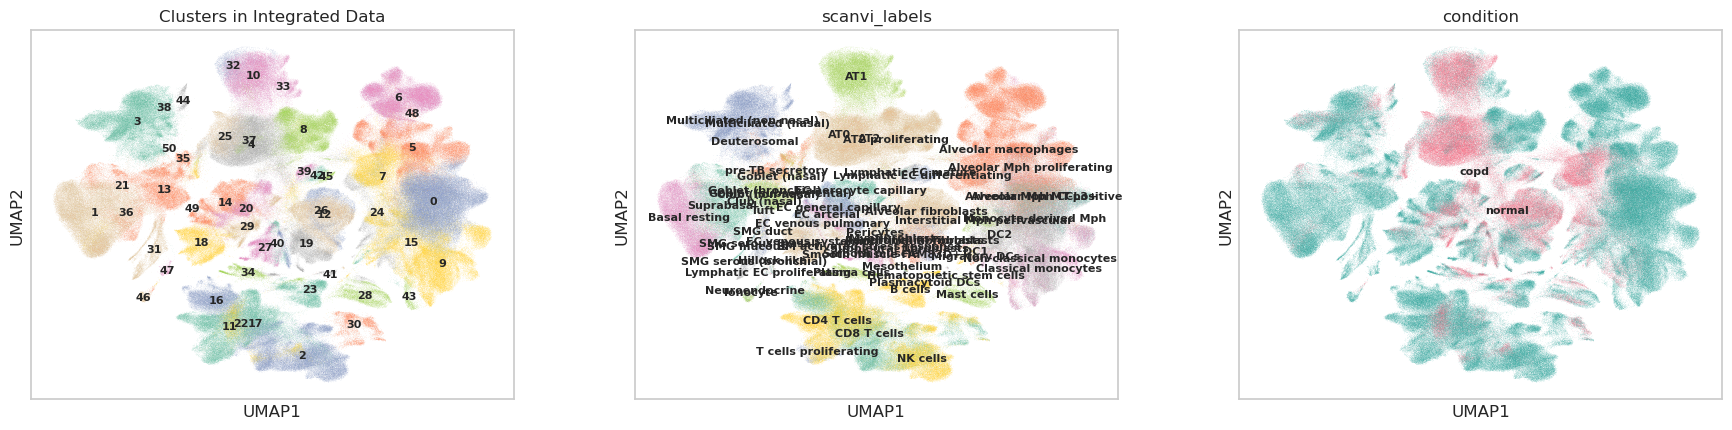

In [176]:
plt.figure(figsize=(8, 6))
sc.pl.umap(adata_scvi, color=['leiden_res0_5', label_key, condition_key], legend_loc='on data', title='Clusters in Integrated Data', legend_fontsize=8, show=False)
plt.show()

<Figure size 800x600 with 0 Axes>

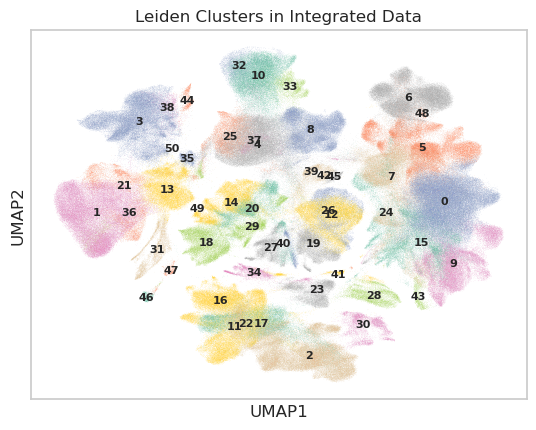

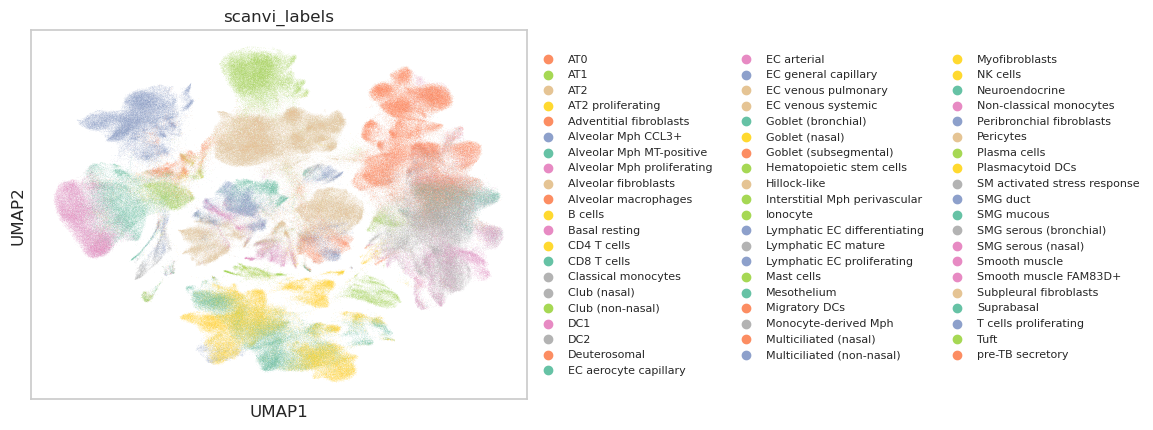

In [178]:
# Define a shared color palette
unique_louvain = adata_scvi.obs['louvain'].unique()
unique_leiden_res0_5 = adata_scvi.obs['leiden_res0_5'].unique()
unique_label_key = adata_scvi.obs[label_key].unique()

# Create a color palette with the maximum number of categories from both keys
max_categories = max(len(unique_louvain), len(unique_leiden_res0_5), len(unique_label_key))
palette = sns.color_palette("Set2", n_colors=max_categories)

# Map the colors to each category for both keys
louvain_colors = {category: palette[i] for i, category in enumerate(unique_louvain)}
leiden_res0_5_colors = {category: palette[i] for i, category in enumerate(unique_leiden_res0_5)}
label_key_colors = {category: palette[i] for i, category in enumerate(unique_label_key)}

# Create the UMAP plot for 'louvain' with legend on data
plt.figure(figsize=(8, 6))
sc.pl.umap(adata_scvi, color=['leiden_res0_5'], 
            palette=leiden_res0_5_colors, 
            legend_loc='on data', 
            title='Leiden Clusters in Integrated Data', 
            legend_fontsize=8, 
            show=False)

# Create a separate plot for 'label_key' with the same palette
sc.pl.umap(adata_scvi, color=[label_key], 
            palette=label_key_colors, 
            legend_loc='right margin', 
            legend_fontsize=8, 
            show=False)

# Show the combined plots
plt.show()


<Figure size 800x600 with 0 Axes>

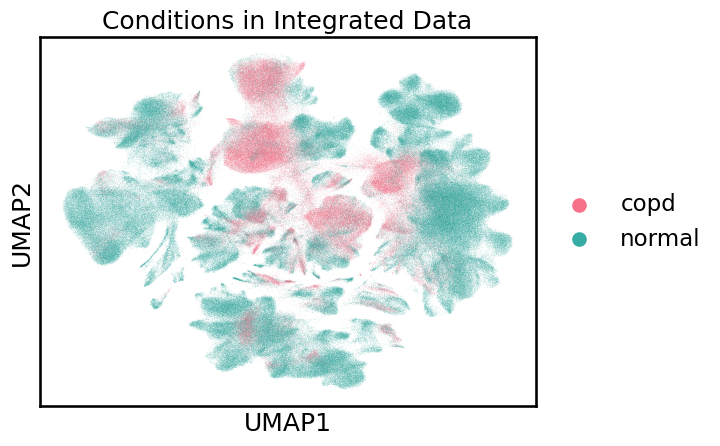

In [18]:
plt.figure(figsize=(8, 6))
sc.pl.umap(adata_scvi, color=['condition'],  title='Conditions in Integrated Data', show=False)
plt.show()

Identify nearest neighbors for each cell

In [19]:
#Get the embedding
X = adata_scvi.obsm['X_scVI']

#### Set the number of neighbors (todo: explore the effect of number of neighbors)

In [20]:
#Fit nearest neighbors model
nbrs = NearestNeighbors(n_neighbors=10).fit(X)
distances, indices = nbrs.kneighbors(X)

### set the cluster label

In [179]:
#Add clustering labels to the anndata
adata_scvi.obs['cluster'] = adata_scvi.obs['leiden_res0_5']

In [ ]:

# copd_gene = pd.read_excel('./copd_genes/literature-1-genes.xlsx', sheet_name='Sheet1')


# print(copd_gene.head())

In [180]:
# arranged_df = copd_gene.groupby('literature_label')['GENE_SYMBOL'].apply(lambda x: ', '.join(x.astype(str).unique())).reset_index()

# # Rename columns for clarity
# arranged_df.columns = ['literature_label', 'GENE_SYMBOL']

# # Display the arranged DataFrame
# arranged_df

### thoughts

- different clusters: COPD score should be comparable
- 

### Cluster-wise: Compute purity scores for every clusters, across condition (copd, normal)

- for each cell, the ratio of copd (purity score), check the consistency by 'the coefficient of variation'
- for each cell, detect spatial patterns (if cells with similar purity scores are spatially clustered) with Moran's I
- for each cluster, there is a purity score (sum of ratio of copd cells/number of cells in the cluster)

In [181]:
# Initialize dictionaries for each metric
copd_purity_scores = {}
normal_purity_scores = {}
copd_cv_scores = {}
normal_cv_scores = {}

# Loop through each cluster
for cluster in adata_scvi.obs['cluster'].unique():
    cluster_cells = adata_scvi[adata_scvi.obs['cluster'] == cluster]
    
    # Separate cells by condition
    copd_cells = cluster_cells[cluster_cells.obs['condition'] == 'copd']
    normal_cells = cluster_cells[cluster_cells.obs['condition'] == 'normal']
    
    copd_purity_ratios = []  # Store COPD purity ratios for CV
    normal_purity_ratios = []  # Store Normal purity ratios for CV
    
    # Initialize counts
    copd_count, normal_count = len(copd_cells), len(normal_cells)
    
    # Only calculate COPD purity if there are COPD cells in the cluster
    if copd_count > 0:
        for i in range(copd_count):
            cell_idx = copd_cells.obs.index[i]  # Target cell index
            neighbors = indices[adata_scvi.obs.index.get_loc(cell_idx)]  # Neighbors of target cell
            num_neighbors_condition = sum(adata_scvi.obs['condition'][neighbors] == 'copd')
            cell_purity_ratio = num_neighbors_condition / len(neighbors)
            copd_purity_ratios.append(cell_purity_ratio)
        copd_purity_scores[cluster] = np.mean(copd_purity_ratios)
        
        # Calculate CV for COPD within this cluster
        copd_cv_scores[cluster] = np.std(copd_purity_ratios) / np.mean(copd_purity_ratios) if np.mean(copd_purity_ratios) > 0 else np.nan
    else:
        copd_purity_scores[cluster] = np.nan
        copd_cv_scores[cluster] = np.nan

    # Only calculate Normal purity if there are Normal cells in the cluster
    if normal_count > 0:
        for i in range(normal_count):
            cell_idx = normal_cells.obs.index[i]
            neighbors = indices[adata_scvi.obs.index.get_loc(cell_idx)]
            num_neighbors_condition = sum(adata_scvi.obs['condition'][neighbors] == 'normal')
            cell_purity_ratio = num_neighbors_condition / len(neighbors)
            normal_purity_ratios.append(cell_purity_ratio)
        normal_purity_scores[cluster] = np.mean(normal_purity_ratios)
        
        # Calculate CV for Normal within this cluster
        normal_cv_scores[cluster] = np.std(normal_purity_ratios) / np.mean(normal_purity_ratios) if np.mean(normal_purity_ratios) > 0 else np.nan
    else:
        normal_purity_scores[cluster] = np.nan
        normal_cv_scores[cluster] = np.nan

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'Cluster': list(copd_purity_scores.keys()),
    'COPD_Purity': list(copd_purity_scores.values()),
    'Normal_Purity': list(normal_purity_scores.values()),
    'COPD_CV': list(copd_cv_scores.values()),
    'Normal_CV': list(normal_cv_scores.values())
})

# Save the DataFrame to a file if needed
# results_df.to_csv('purity_cv_results.csv', index=False)

# Display DataFrame if needed for quick verification
results_df.head()


,Cluster,COPD_Purity,Normal_Purity,COPD_CV,Normal_CV
0,20,0.771888,0.450342,0.271667,0.482033
1,5,0.477645,0.967024,0.569740,0.103672
2,0,0.326316,0.982727,0.680485,0.071144
3,1,0.256522,0.996816,0.803254,0.026623
4,28,0.660496,0.870701,0.373308,0.223123


In [182]:
results_df

,Cluster,COPD_Purity,Normal_Purity,COPD_CV,Normal_CV
0,20,0.771888,0.450342,0.271667,0.482033
1,5,0.477645,0.967024,0.569740,0.103672
2,0,0.326316,0.982727,0.680485,0.071144
3,1,0.256522,0.996816,0.803254,0.026623
4,28,0.660496,0.870701,0.373308,0.223123
5,11,0.400000,0.977769,0.655842,0.086195
6,7,0.838874,0.389252,0.268425,0.609568
7,6,0.388889,0.997811,0.410077,0.025039
8,17,0.329743,0.928400,0.554387,0.125115
9,21,0.600697,0.938935,0.446276,0.143980


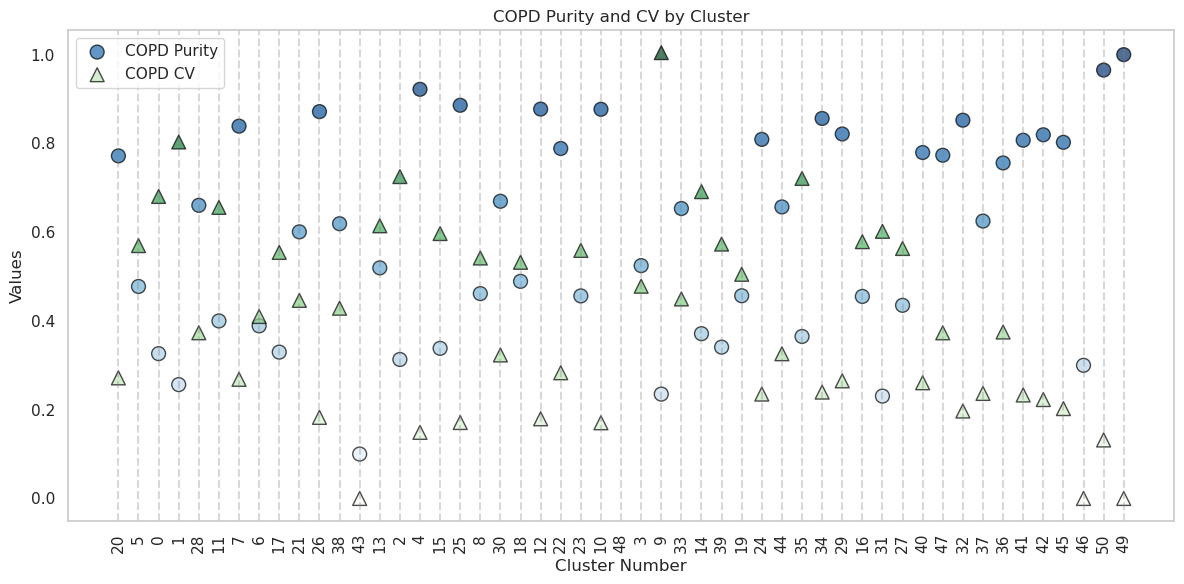

In [183]:


# Assume results_df is already defined

# Normalize the values to get a color scale from 0 to 1
purity_colors = results_df['COPD_Purity'] / results_df['COPD_Purity'].max()
cv_colors = results_df['COPD_CV'] / results_df['COPD_CV'].max()

# Create a combined scatter plot
plt.figure(figsize=(12, 6))

# Scatter plot for COPD Purity (circle markers)
plt.scatter(results_df['Cluster'], results_df['COPD_Purity'], 
            color=plt.cm.Blues(purity_colors),  # Use blue colormap for purity
            s=100, label='COPD Purity', edgecolor='black', alpha=0.7, marker='o')

# Scatter plot for COPD CV (triangle markers)
plt.scatter(results_df['Cluster'], results_df['COPD_CV'], 
            color=plt.cm.Greens(cv_colors),  # Use green colormap for CV
            s=100, label='COPD CV', edgecolor='black', alpha=0.7, marker='^')

# Adding vertical dashed lines for each cluster value
for cluster_value in results_df['Cluster']:
    plt.axvline(x=cluster_value, color='grey', linestyle='--', alpha=0.3)

# Adding titles and labels
plt.title('COPD Purity and CV by Cluster')
plt.xlabel('Cluster Number')
plt.ylabel('Values')
plt.xticks(rotation=90)

# Adding a legend
plt.legend()

# Adding a grid for better visibility
plt.grid()

# Show the plot
plt.tight_layout()
plt.show()


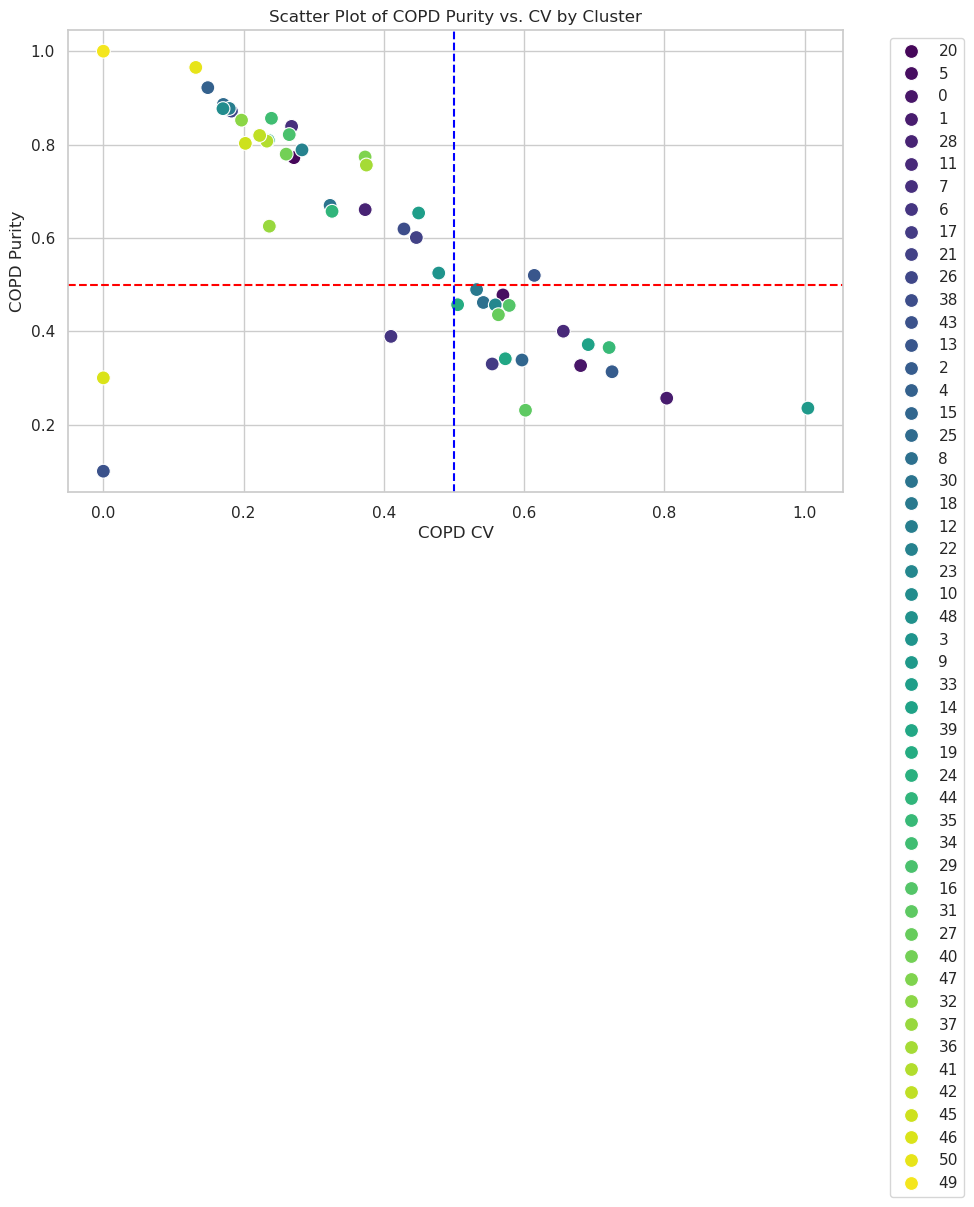

In [184]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=results_df, x='COPD_CV', y='COPD_Purity', hue='Cluster', palette='viridis', s=100)
plt.title('Scatter Plot of COPD Purity vs. CV by Cluster')
plt.xlabel('COPD CV')
plt.ylabel('COPD Purity')
plt.axhline(0.5, color='red', linestyle='--')  # Optional line for reference
plt.axvline(0.5, color='blue', linestyle='--')  # Optional line for reference
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [186]:
from scipy.stats import pearsonr, spearmanr

# Drop rows with NaN or infinite values in 'COPD_CV' or 'COPD_Purity'
cleaned_df = results_df.replace([np.inf, -np.inf], np.nan).dropna(subset=['COPD_CV', 'COPD_Purity'])

# Now calculate Pearson and Spearman correlations on the cleaned data
pearson_corr, pearson_p = pearsonr(cleaned_df['COPD_CV'], cleaned_df['COPD_Purity'])
print(f"Pearson Correlation: {pearson_corr}, p-value: {pearson_p}")

# Spearman correlation (for monotonic relationships)
spearman_corr, spearman_p = spearmanr(cleaned_df['COPD_CV'], cleaned_df['COPD_Purity'])
print(f"Spearman Correlation: {spearman_corr}, p-value: {spearman_p}")

Pearson Correlation: -0.6838771799683305, p-value: 4.392095447440826e-08
Spearman Correlation: -0.738846471256037, p-value: 9.022281773576605e-10


#### based on the scatter plot, and the pearson correlation, we know CV and purity has a high value of correlation

## Calculate disease-specific gene signatures

Create a lower resolution of HLCA labels


In [ ]:
# adata_scvi.obs

In [187]:
label_mapping = pd.read_excel('./copd_genes/literature-1-mapping.xlsx') 
label_mapping

,literature_label,hlca_label,GENE_SYMBOL
0,Alveolar typ 1 epitheial cell,AT1,"GDF15, SELM, FTL, XPC, S100A4, FOLR1"
1,Alveolar type 2 epithelial,AT2,"FGG, CYP1B1, NNMT, HIF1A, KDELR2, DNAJB9, MGST..."
2,B,B cells,"FCRLA, NNMT, S100A9, TIMP1, FKBP11, SRPRB, FTL..."
3,Ciliated epithelial,Multiciliated (non-nasal),"FGA, RPRML, SAA1, KRT23, DHRS9, TMEM154, BASP1..."
4,Ciliated epithelial,Multiciliated (nasal),"FGA, RPRML, SAA1, KRT23, DHRS9, TMEM154, BASP1..."
5,Cytotoxic T cell,CD8 T cells,"CYP1B1, CXCR5, NNMT, S100A9, TMEM154, FKBP11, ..."
6,Endothelial cell,EC aerocyte capillary,"SPP1, FTL, RRAS, BST2, CLEC14A, CDO1, RAMP2, M..."
7,Endothelial cell,EC venous systemic,"SPP1, FTL, RRAS, BST2, CLEC14A, CDO1, RAMP2, M..."
8,Endothelial cell,EC general capillary,"SPP1, FTL, RRAS, BST2, CLEC14A, CDO1, RAMP2, M..."
9,Endothelial cell,EC arterial,"SPP1, FTL, RRAS, BST2, CLEC14A, CDO1, RAMP2, M..."


In [188]:
import pandas as pd

# Sample DataFrame creation for demonstration


# Format the GENE_SYMBOL column to return lists of genes
def format_gene_symbols(gene_string):
    # Split by ',' and strip whitespace from each gene
    return [gene.strip() for gene in gene_string.split(',')]

# Apply the formatting function to the GENE_SYMBOL column
label_mapping['GENE_SYMBOL'] = label_mapping['GENE_SYMBOL'].apply(format_gene_symbols)

# Generate gene signatures as lists of unique genes for each hlca_label
gene_signatures = label_mapping.groupby('hlca_label')['GENE_SYMBOL'].apply(lambda x: list(set(gene for sublist in x for gene in sublist))).to_dict()

# Display the generated gene signatures
print(gene_signatures)


{'AT1': ['FTL', 'S100A4', 'XPC', 'GDF15', 'SELM', 'FOLR1'], 'AT2': ['CYP1B1', 'NNMT', 'TGFBR2', 'SRM', 'RPL39', 'EEF1B2', 'DNAJB9', 'PTRF', 'CAPN2', 'FGG', 'RPL22L1', 'S100A10', 'GKN2', 'KDELR2', 'S100A6', 'MGST1', 'ANXA11', 'HIF1A'], 'Adventitial fibroblasts': ['CLEC3B'], 'Alveolar fibroblasts': ['CLEC3B'], 'B cells': ['NNMT', 'FCRLA', 'FKBP11', 'FTL', 'S100A9', 'CAV1', 'GNG11', 'AGER', 'SRPRB', 'S100A6', 'TIMP1'], 'CD4 T cells': ['NNMT', 'FKBP11', 'FTL', 'CAV1', 'S100A9', 'IFI27', 'AGER', 'RPL22L1', 'S100A10', 'S100A6', 'TIMP1'], 'CD8 T cells': ['PTRF', 'RPL22L1', 'S100A10', 'CRIP1', 'S100A6', 'TIMP1', 'CYP1B1', 'FTL', 'S100A9', 'GNG11', 'SPCS3', 'RPS10', 'DPH3', 'CAV1', 'CXCR5', 'TGFBR3', 'IFI27', 'NNMT', 'FKBP11', 'RPL36', 'TMEM154', 'AGER', 'MMD'], 'Classical monocytes': ['TM4SF19', 'CELF2', 'SYT17', 'OASL', 'SPP1', 'SLC35E4', 'MCFD2', 'SERTAD2', 'OSM', 'RPL22L1', 'TIMP4', 'TTC7A', 'S100A10', 'SH3PXD2B', 'MGST1', 'CRIP1', 'SLC16A10', 'HIF1A', 'CCNC', 'RRAS', 'CYP1B1', 'FTL', 'DERL

In [189]:
label_mapping

,literature_label,hlca_label,GENE_SYMBOL
0,Alveolar typ 1 epitheial cell,AT1,"[GDF15, SELM, FTL, XPC, S100A4, FOLR1]"
1,Alveolar type 2 epithelial,AT2,"[FGG, CYP1B1, NNMT, HIF1A, KDELR2, DNAJB9, MGS..."
2,B,B cells,"[FCRLA, NNMT, S100A9, TIMP1, FKBP11, SRPRB, FT..."
3,Ciliated epithelial,Multiciliated (non-nasal),"[FGA, RPRML, SAA1, KRT23, DHRS9, TMEM154, BASP..."
4,Ciliated epithelial,Multiciliated (nasal),"[FGA, RPRML, SAA1, KRT23, DHRS9, TMEM154, BASP..."
5,Cytotoxic T cell,CD8 T cells,"[CYP1B1, CXCR5, NNMT, S100A9, TMEM154, FKBP11,..."
6,Endothelial cell,EC aerocyte capillary,"[SPP1, FTL, RRAS, BST2, CLEC14A, CDO1, RAMP2, ..."
7,Endothelial cell,EC venous systemic,"[SPP1, FTL, RRAS, BST2, CLEC14A, CDO1, RAMP2, ..."
8,Endothelial cell,EC general capillary,"[SPP1, FTL, RRAS, BST2, CLEC14A, CDO1, RAMP2, ..."
9,Endothelial cell,EC arterial,"[SPP1, FTL, RRAS, BST2, CLEC14A, CDO1, RAMP2, ..."


### per-cell type score

In [191]:


# Initialize a dictionary to store the average gene expression scores
average_expression_scores = {}

# Loop through each cell type in gene signatures
for cell_type, genes in gene_signatures.items():
    # Find matching genes in adata_scvi.var
    matched_genes = [gene for gene in genes if gene in adata_scvi.var['gene_symbols'].values]
    if matched_genes:
        # Get Ensembl IDs for matched genes
        matched_ensembl_ids = adata_scvi.var[adata_scvi.var['gene_symbols'].isin(matched_genes)].index
        
        # Select cells of the current cell type
        cells_of_type = adata_scvi[adata_scvi.obs[label_key] == cell_type]

        if cells_of_type.n_obs > 0:
            # Get indices of matched Ensembl IDs in adata_scvi.var
            gene_indices = adata_scvi.var.index.get_indexer(matched_ensembl_ids)

            # Filter out any -1 indices (which indicate unmatched genes)
            valid_gene_indices = gene_indices[gene_indices != -1]

            # Ensure we have valid indices to use for gene expression retrieval
            if valid_gene_indices.size > 0:
                # Get the gene expression matrix for the matched genes
                gene_expression = cells_of_type.X[:, valid_gene_indices]
                
                # Calculate the mean gene expression for matched genes
                average_expression = gene_expression.mean(axis=1)  # Mean across genes for each cell
                average_expression_scores[cell_type] = average_expression.mean()  # Average across all cells of this type
            else:
                average_expression_scores[cell_type] = np.nan
        else:
            average_expression_scores[cell_type] = np.nan
    else:
        average_expression_scores[cell_type] = np.nan

# Create a new DataFrame to store results
expression_scores_df = pd.DataFrame(list(average_expression_scores.items()), columns=['cell_type', 'average_gene_expression'])

# Display the new DataFrame
print(expression_scores_df)


                       cell_type  average_gene_expression
0                            AT1                 0.210086
1                            AT2                 0.341987
2        Adventitial fibroblasts                      NaN
3           Alveolar fibroblasts                      NaN
4                        B cells                 0.059271
5                    CD4 T cells                 0.079504
6                    CD8 T cells                 0.153286
7            Classical monocytes                 0.223205
8                   Club (nasal)                 0.022137
9               Club (non-nasal)                 0.018325
10         EC aerocyte capillary                 0.593890
11                   EC arterial                 0.708156
12          EC general capillary                 0.733592
13           EC venous pulmonary                 0.482286
14            EC venous systemic                 0.735871
15  Lymphatic EC differentiating                 0.457884
16           L

### per-clusterxcell_type score

In [192]:
# Initialize a dictionary to store the average gene expression scores per cluster
average_expression_scores_per_cluster = {}

# Loop through each unique cluster
for cluster in adata_scvi.obs['cluster'].unique():
    # Select cells belonging to the current cluster
    cells_in_cluster = adata_scvi[adata_scvi.obs['cluster'] == cluster]
    
    # Initialize a dictionary to store average expression for each cell type within this cluster
    cluster_gene_scores = {}

    # Loop through each cell type in gene signatures
    for cell_type, genes in gene_signatures.items():
        # Match genes in the current signature to genes available in adata_scvi
        matched_genes = [gene for gene in genes if gene in adata_scvi.var['gene_symbols'].values]
        
        if matched_genes:
            # Get Ensembl IDs for matched genes
            matched_ensembl_ids = adata_scvi.var[adata_scvi.var['gene_symbols'].isin(matched_genes)].index
            
            # Get indices of matched Ensembl IDs
            gene_indices = adata_scvi.var.index.get_indexer(matched_ensembl_ids)
            valid_gene_indices = gene_indices[gene_indices != -1]  # Remove any unmatched genes
            
            if valid_gene_indices.size > 0:
                # Get gene expression matrix for the matched genes in the current cluster
                gene_expression = cells_in_cluster.X[:, valid_gene_indices]
                
                # Calculate mean expression for these genes across cells in the cluster
                average_expression = gene_expression.mean(axis=1)  # Mean across genes for each cell
                cluster_gene_scores[cell_type] = average_expression.mean()  # Average across all cells
            else:
                cluster_gene_scores[cell_type] = np.nan
        else:
            cluster_gene_scores[cell_type] = np.nan

    # Store scores for this cluster
    average_expression_scores_per_cluster[cluster] = cluster_gene_scores

# Convert the nested dictionary to a DataFrame for easier visualization
expression_scores_df = pd.DataFrame.from_dict(average_expression_scores_per_cluster, orient='index')

# Display the DataFrame
print(expression_scores_df)


         AT1       AT2  Adventitial fibroblasts  Alveolar fibroblasts  \
20  0.138474  0.408297                      NaN                   NaN   
5   1.260975  0.075021                      NaN                   NaN   
0   1.093112  0.056432                      NaN                   NaN   
1   0.218661  0.121677                      NaN                   NaN   
28  0.951787  0.098551                      NaN                   NaN   
11  1.118885  0.076118                      NaN                   NaN   
7   0.364848  0.120004                      NaN                   NaN   
6   1.427588  0.047183                      NaN                   NaN   
17  0.546629  0.042861                      NaN                   NaN   
21  0.409182  0.145031                      NaN                   NaN   
26  0.109906  0.196121                      NaN                   NaN   
38  0.139323  0.072372                      NaN                   NaN   
43  0.463627  0.020191                      NaN    

### per-cluster score

### import numpy as np
import pandas as pd

# Initialize a dictionary to store the average gene expression scores per cluster
average_expression_scores_per_cluster = {}

# Loop through each unique cluster
for cluster in adata_scvi.obs['cluster'].unique():
    # Select cells belonging to the current cluster
    cells_in_cluster = adata_scvi[adata_scvi.obs['cluster'] == cluster]
    
    # Initialize a list to collect mean expressions for each cell type within this cluster
    cell_type_means = []

    # Loop through each cell type in gene signatures
    for cell_type, genes in gene_signatures.items():
        # Match genes in the current signature to genes available in adata_scvi
        matched_genes = [gene for gene in genes if gene in adata_scvi.var['gene_symbols'].values]
        
        if matched_genes:
            # Get Ensembl IDs for matched genes
            matched_ensembl_ids = adata_scvi.var[adata_scvi.var['gene_symbols'].isin(matched_genes)].index
            
            # Get indices of matched Ensembl IDs
            gene_indices = adata_scvi.var.index.get_indexer(matched_ensembl_ids)
            valid_gene_indices = gene_indices[gene_indices != -1]  # Remove any unmatched genes
            
            if valid_gene_indices.size > 0:
                # Get gene expression matrix for the matched genes in the current cluster
                gene_expression = cells_in_cluster.X[:, valid_gene_indices]
                
                # Calculate mean expression for these genes across cells in the cluster
                average_expression = gene_expression.mean(axis=1)  # Mean across genes for each cell
                cell_type_mean_expression = average_expression.mean()  # Average across all cells for this cell type
                
                # Append the mean expression of this cell type
                cell_type_means.append(cell_type_mean_expression)
            else:
                cell_type_means.append(np.nan)
        else:
            cell_type_means.append(np.nan)

    # Calculate the mean expression across all cell types for this cluster
    overall_mean_expression = np.nanmean(cell_type_means)
    average_expression_scores_per_cluster[cluster] = overall_mean_expression

# Create a new DataFrame to store results
expression_scores_df = pd.DataFrame(
    list(average_expression_scores_per_cluster.items()), 
    columns=['cluster', 'overall_mean_gene_expression']
)

# Display the new DataFrame
print(expression_scores_df)


In [194]:
expression_scores_df

,cluster,overall_mean_gene_expression
0,20,0.406944
1,5,0.281650
2,0,0.262859
3,1,0.118543
4,28,0.169288
5,11,0.171938
6,7,0.159612
7,6,0.262436
8,17,0.133202
9,21,0.216343


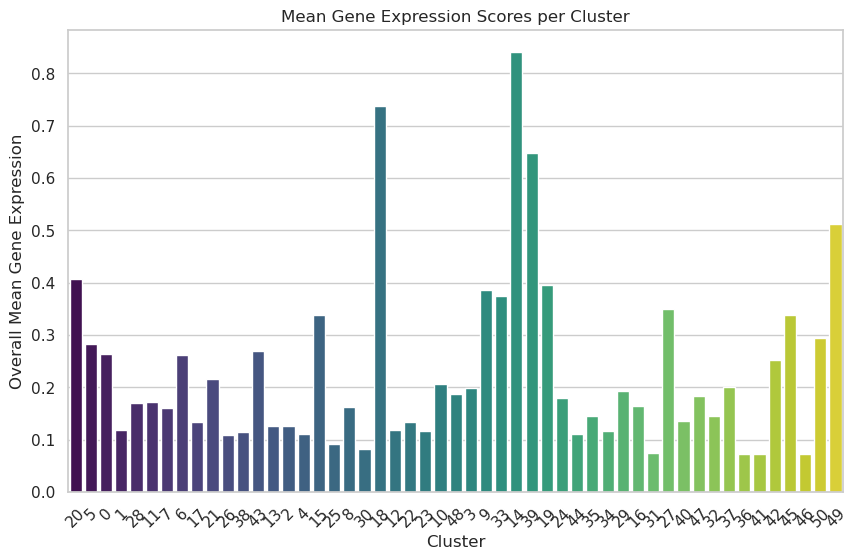

In [195]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plot size and style
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# Create a bar plot of mean gene expression scores per cluster
sns.barplot(data=expression_scores_df, x='cluster', y='overall_mean_gene_expression', palette='viridis')

# Add titles and labels
plt.title('Mean Gene Expression Scores per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Overall Mean Gene Expression')

# Display the plot
plt.xticks(rotation=45)  # Rotate cluster labels for better readability, if needed
plt.show()


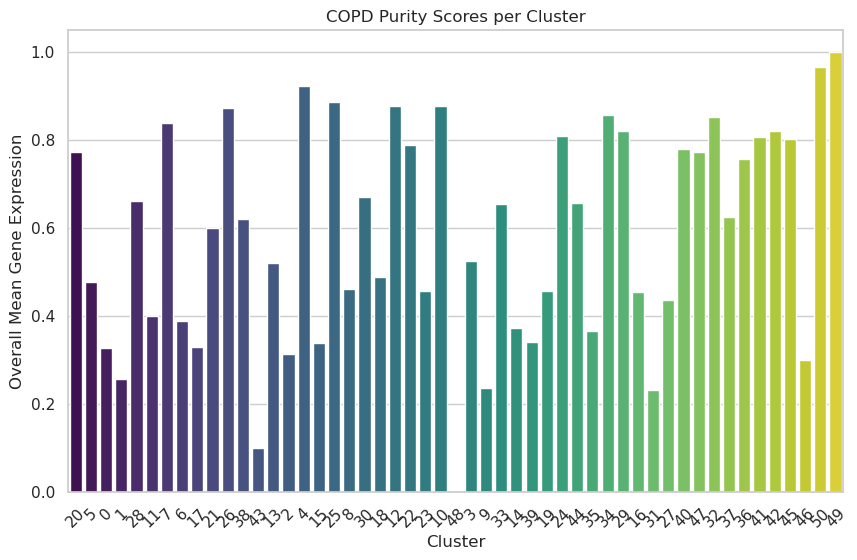

In [206]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plot size and style
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# Create a bar plot of mean gene expression scores per cluster
sns.barplot(data=results_df, x='Cluster', y='COPD_Purity', palette='viridis')

# Add titles and labels
plt.title('COPD Purity Scores per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Overall Mean Gene Expression')

# Display the plot
plt.xticks(rotation=45)  # Rotate cluster labels for better readability, if needed
plt.show()


In [202]:
results_df

,Cluster,COPD_Purity,Normal_Purity,COPD_CV,Normal_CV
0,20,0.771888,0.450342,0.271667,0.482033
1,5,0.477645,0.967024,0.569740,0.103672
2,0,0.326316,0.982727,0.680485,0.071144
3,1,0.256522,0.996816,0.803254,0.026623
4,28,0.660496,0.870701,0.373308,0.223123
5,11,0.400000,0.977769,0.655842,0.086195
6,7,0.838874,0.389252,0.268425,0.609568
7,6,0.388889,0.997811,0.410077,0.025039
8,17,0.329743,0.928400,0.554387,0.125115
9,21,0.600697,0.938935,0.446276,0.143980


### correlation analysis results_df['COPD_Purity'] and expression_scores_df

In [197]:
# Replace inf and -inf with NaN, then drop rows with NaN in either column
cleaned_df = pd.DataFrame({
    'overall_mean_gene_expression': expression_scores_df['overall_mean_gene_expression'],
    'COPD_Purity': results_df['COPD_Purity']
}).replace([np.inf, -np.inf], np.nan).dropna()

# Check if any rows were dropped (optional)
print(f"Rows before cleaning: {len(expression_scores_df)}, Rows after cleaning: {len(cleaned_df)}")

# Calculate Pearson and Spearman correlations on the cleaned data
pearson_corr, pearson_p = pearsonr(cleaned_df['overall_mean_gene_expression'], cleaned_df['COPD_Purity'])
print(f"Pearson Correlation: {pearson_corr}, p-value: {pearson_p}")

spearman_corr, spearman_p = spearmanr(cleaned_df['overall_mean_gene_expression'], cleaned_df['COPD_Purity'])
print(f"Spearman Correlation: {spearman_corr}, p-value: {spearman_p}")

Rows before cleaning: 51, Rows after cleaning: 50
Pearson Correlation: -0.184176651379031, p-value: 0.20041446470344387
Spearman Correlation: -0.15361344537815122, p-value: 0.286841999662088


In [200]:
# Replace inf and -inf with NaN, then drop rows with NaN in either column
cleaned_df = pd.DataFrame({
    'overall_mean_gene_expression': expression_scores_df['overall_mean_gene_expression'],
    'COPD_CV': results_df['COPD_CV']
}).replace([np.inf, -np.inf], np.nan).dropna()

# Check if any rows were dropped (optional)
print(f"Rows before cleaning: {len(expression_scores_df)}, Rows after cleaning: {len(cleaned_df)}")

# Calculate Pearson and Spearman correlations on the cleaned data
pearson_corr, pearson_p = pearsonr(cleaned_df['overall_mean_gene_expression'], cleaned_df['COPD_CV'])
print(f"Pearson Correlation: {pearson_corr}, p-value: {pearson_p}")

spearman_corr, spearman_p = spearmanr(cleaned_df['overall_mean_gene_expression'], cleaned_df['COPD_CV'])
print(f"Spearman Correlation: {spearman_corr}, p-value: {spearman_p}")

Rows before cleaning: 51, Rows after cleaning: 50
Pearson Correlation: 0.211504473017892, p-value: 0.1403540407386915
Spearman Correlation: 0.17840849143426568, p-value: 0.21512176834275287
